<a href="https://colab.research.google.com/github/GreggHeller1/PMT_linearization/blob/main/scripts/demo_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
# settings
%load_ext autoreload
%autoreload 2
try:
    import google.colab

    in_colab = True
except:
    in_colab = False
print(in_colab)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
False


In [25]:
# installs (for colab only, run this once)
if in_colab:
    ! git clone https://github.com/GreggHeller1/PMT_linearization.git

In [142]:
# local imports
# cwd if in colab for imports to work
if in_colab:
    %cd /content/PMT_linearization

from src import data_io as io
from src import demo_plotting as plot
from src import demo_computation as comp

In [27]:
# imports
# import xarray as xr
import pandas as pd
from matplotlib import pyplot as plt

import os
import numpy as np

In [28]:
# define paths
# cwd if in colab for file loading to work
if in_colab:
    %cd /content/PMT_linearization/scripts

test_path = os.path.join("demo_data", "test.txt")
print(test_path)
print(os.getcwd())
os.path.exists(test_path)

demo_data/test.txt
/Users/greggoryheller/Documents/code/PMT_linearization/scripts


True

In [29]:
# data inputs
io.readfile(test_path)

Reading file at demo_data/test.txt
Testing whether we can read the contents of a text file in colab

maybe we need another line?


#Spectral unmixing for multiple flourophores in-vivo
When doing in-vivo 2 photon imaging, resolving multiple flourophores is often assumed to require spectrally distinct flourophores with a seperatne detection channel for each. i.e. To image a red flourophore (tdtomato) and a green flourophore (GFP) that emit photons at two distinct wavelengths (580 and 508). Photons can be seperated by wavelength using dichroic mirrors and filters so that those photons above 550 (mostly from tdtomato) go to one detector, and those below 550 (mostly from GFP) go to a different detector. 

* But what if the emission spectra are mostly overlapping? Even with well seperated flourophres there is often some overlap (e.g. some photons emitted by GFP will be detected in the red channel) 

* or what if you want to distinguish more colors with a limited number of detectors/PMTs? 

Spectral unmixing can accomplish this. 

1
1
1


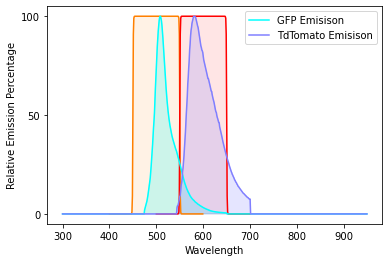

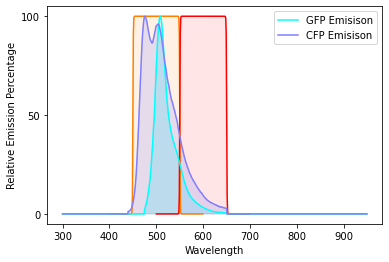

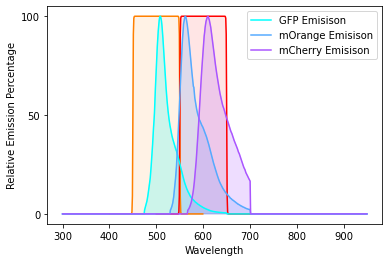

In [38]:
# load in excitation and emission for all 4
def load_exc_em(csv_name):
    path = os.path.join("demo_data", csv_name)
    df = pd.read_csv(path)
    return df


# create the red and green filters
# total range is 300:949
# green is 470:550
# red can be 550:650

spectra_mapping = {
    "YFP": "YFP.csv",
    "CFP": "CFP.csv",
    "GFP": "GFP.csv",
    "mOrange": "mOrangeFP.csv",
    "mCherry": "mCherryFP.csv",
    "TdTomato": "tdTomatoFP.csv",
    "Blue FluoSpheres": "BFS.csv",
    "Crimson FluoSpheres": "CrFS.csv",
    "Dark Red FluoSpheres": "DRFS.csv",
    "Nile Red FluoSpheres": "NRFS.csv",
    "YellowGreen FluoSpheres": "YGFS.csv",
    "Orange FluoSpheres": "OFS.csv",
}


def load_all_spectra(spectra_mapping):
    spectra_dict = {}
    for FP_name, csv_name in spectra_mapping.items():
        spectra_dict[FP_name] = load_exc_em(csv_name)
    return spectra_dict


all_fps = load_all_spectra(spectra_mapping)


all_filters = {}
all_filters["Red Filter"] = comp.create_filter(600, 100, max_em=100, steepness=10)
all_filters["Green Filter"] = comp.create_filter(500, 100, max_em=100, steepness=10)


# then we plot the excitation and emission curves, and the filters


def get_sub_dict(key_list: list, dict_: dict) -> dict:
    # new_dict = {}
    # for key in key_list:
    #    new_dict[key] = dict_[key]
    return {key: dict_[key] for key in key_list}


fp_dict = get_sub_dict(["GFP", "TdTomato"], all_fps)

filter_dict = get_sub_dict(["Green Filter", "Red Filter"], all_filters)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

fp_dict = get_sub_dict(["GFP", "CFP"], all_fps)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

fp_dict = get_sub_dict(["GFP", "mOrange", "mCherry"], all_fps)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

#How does spectral unmixing work?

Spectral unmixing relies on the property that the distribution of photon wavelengths emitted by a flourophore is consistent and independant of the total number of photons emmitted by that type of flourophore. If you know that all the photons collected must've been produced by specific flourophores, then the photons collected at a given excitation pixel must be a linear combination of the photons that can be produced by individual flourophores. As long as the number of effective detection channels meets or exceeds the number of flourophores, and that the effective spectra of the flourophores are LINEARLY INDEPENDANT then we can use linear algebra to solve for the amounts of the flourophores. 

We solve the linear system of equations 
$$
\textbf{A} \vec{x} = \vec{b}
$$
For $C$ detection channels, $\vec{b}$ is the vector of length $C$ with the $c$th entry representing the photons detected in the $c$th channel for a given pixel. For $N$ flourophores, $\textbf{A}$ is an $C$x$N$ matrix where each entry $A_{c,n}$ is the fraction of total emmision from the $c$th flourophore that will be detected in $n$th channel. $\vec{x}$ is a vector of length $N$ with the $n$th entry being the inferred amount of the $n$th flourophore. 



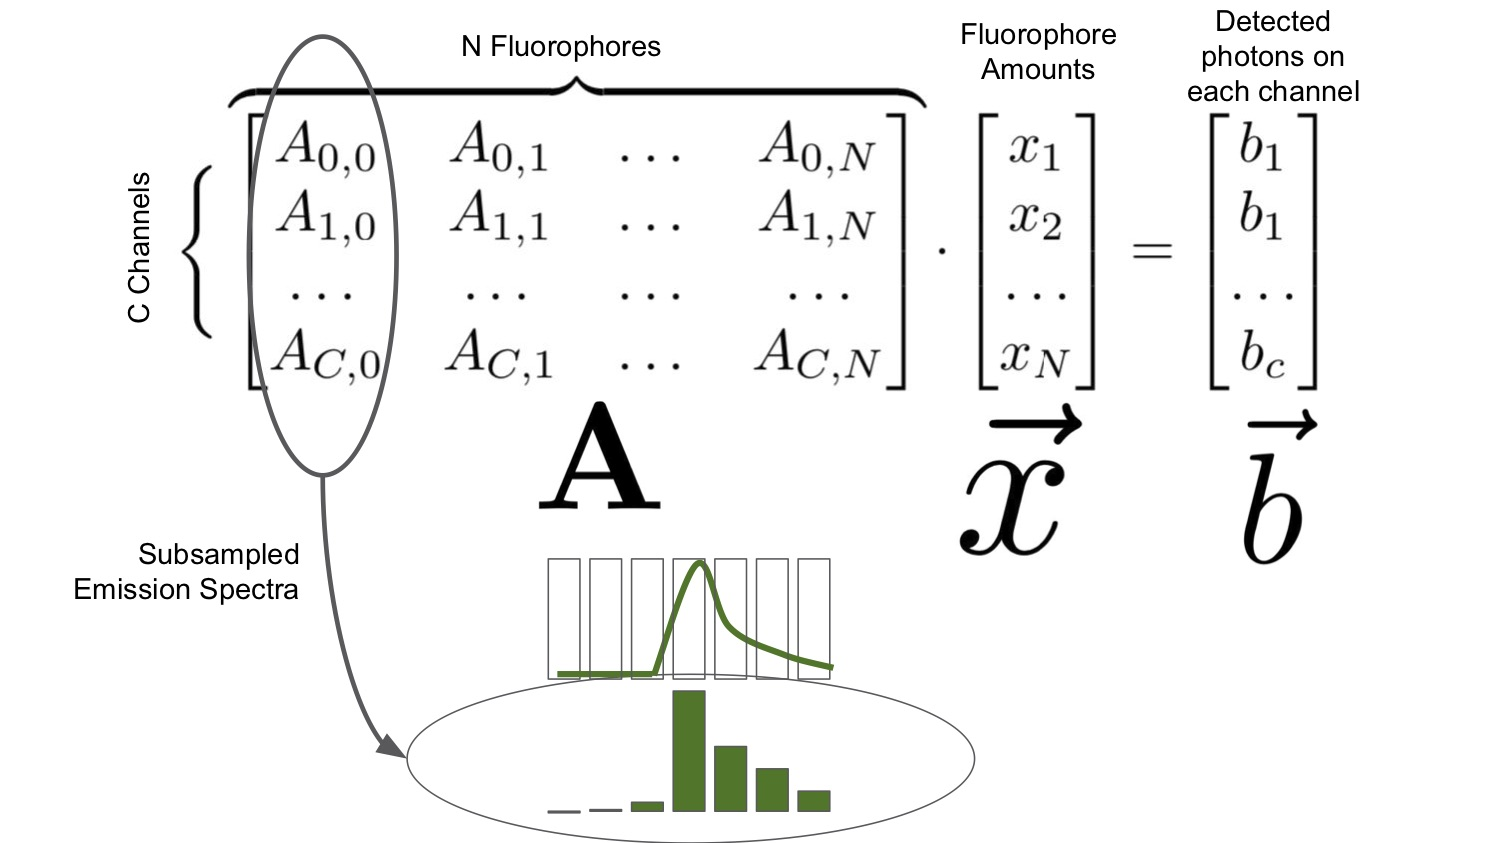

#Example 1: TdTomato and GFP


In [39]:
def get_A(Filter_list, FP_list):
    A = np.zeros((len(Filter_list), len(FP_list)))
    for i, filter in enumerate(Filter_list):
        filter_df = filter_dict[filter]
        for j, FP in enumerate(FP_list):
            spectra_df = spectra_dict[FP]
            A[i, j] = apply_filter(spectra_df, filter_df)

    row_sums = A.sum(axis=0)
    A = A / row_sums[np.newaxis, :]
    return A


def main_2_by_2(FP_list, Filter_list, x_known, two_channels=False):
    A = get_A(Filter_list, FP_list)

    b, x_inferred, res = mock_unmixing(A, x_known)

    unmixing_plots(
        A, b, x_known, x_inferred, two_channels=two_channels, label_list=FP_list
    )

1


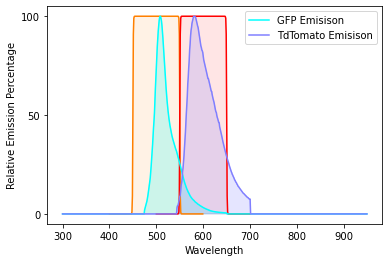

In [48]:
fp_dict = get_sub_dict(["GFP", "TdTomato"], all_fps)
filter_dict = get_sub_dict(["Green Filter", "Red Filter"], all_filters)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_inferred, res, rank, s = np.linalg.lstsq(A, b)


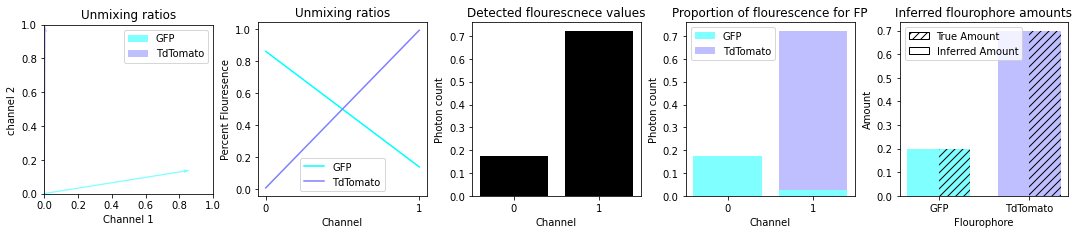

In [49]:
# @title { run: "auto" }
GFP_amount = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
tdTomato_amount = 0.7  # @param {type:"slider", min:0, max:1, step:0.1}
x_known = np.array([GFP_amount, tdTomato_amount])

# main_2_by_2(FP_list, Filter_list, x_known, two_channels=True)
comp.main(fp_dict, filter_dict, x_known, two_channels=True)

#Example 1 conclusions
For this example the effect is essentially cleaning up the red and green signals. This is because the two flourophores are quite seperable, and the filter set is well aligned to seperate them. However this need not be the case. The only requirement is that the unmixing coefficients (columns of the matrix $\textbf{A}$) be linearly independant. 

Note that even when the two signals are easily seperable, without unmixing the seperation is imperfect. If you are using a both an activity indicator (Geci) and a structural marker in tandem to help account for motion artifacts - you should really unmix the signals to make sure that your real activity is not leaking into your static structural channel. 

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_inferred, res, rank, s = np.linalg.lstsq(A, b)


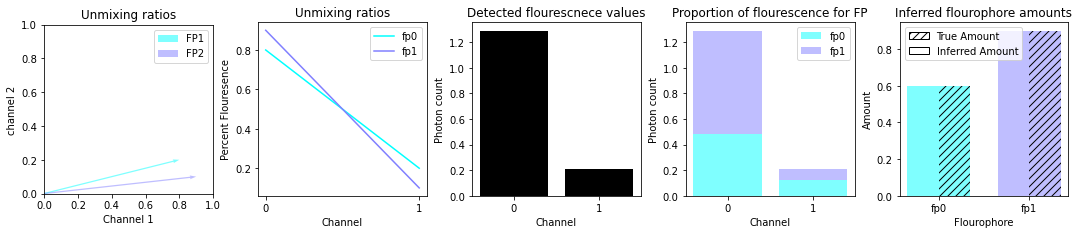

In [51]:
# @title Example 2: two arbitrary flourophores { run: "auto" }
# @markdown ####Flourophore ratio = (emission in channel 2)/(emission in channel 1)

fp_A_ratio = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
fp_B_ratio = 0.1  # @param {type:"slider", min:0, max:1, step:0.1}

A = np.array([[1 - fp_A_ratio, fp_A_ratio], [1 - fp_B_ratio, fp_B_ratio]])
A = A.T

fp_A_amount = 0.6  # @param {type:"slider", min:0, max:1, step:0.1}
fp_B_amount = 0.9  # @param {type:"slider", min:0, max:1, step:0.1}
x_known = np.array([fp_A_amount, fp_B_amount])

b, x_inferred, res = comp.mock_unmixing(A, x_known)

plot.unmixing_plots(A, b, x_known, x_inferred, two_channels=True)

#Example 2 conclusions:
From this example we can see that it is not necessary that the flourophores be highly seperable, or that the filter sets be well aligned, as long as the combination is sufficient to render the unmixing coefficiencts linearly independant. However, be WARNED! the less seperable the flourophores are, the more susceptible the unmixing will be to errors from noise from various sources. If the unmixing coefficients are very similar, then small fluctuations in the detected photons can lead to large changes in the estimated fluorophore amounts. 

At the end of the notebook we will explore possible sources of noise and try to determine when accurate unmixing is possible. 



#Increasing the number of effective channels

In the first two examples we looked at examples with two flourophores and two detection channels. If you want to image more than two colors, you need a way to increase the effective number of channels. Having fewer channels than flourophores will mean that the unmixing coefficients are not linearly independant so the the number of effective channels must always be greater than or equal to the number of distinct fluorophores. Lets look at an example with GFP, mOrange and mCherry to see a few examples of how this might work. 


1


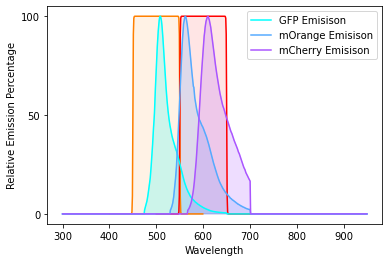

In [52]:
fp_dict = get_sub_dict(["GFP", "mOrange", "mCherry"], all_fps)
filter_dict = get_sub_dict(["Green Filter", "Red Filter"], all_filters)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

#1. Adding an additional PMT
The simplest way to increase the number of channels is to add an additional PMT and filter set. As long as the proportions of flouresence in the new channel are not identical to those in another channel, this will render the unmixing coefficients linearly independant and allow for unmixing.

1


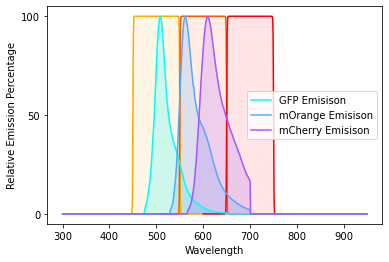

In [56]:
all_filters["Far Red Filter"] = comp.create_filter(700, 100, max_em=100, steepness=10)
fp_dict = get_sub_dict(["GFP", "mOrange", "mCherry"], all_fps)
filter_dict = get_sub_dict(
    ["Green Filter", "Red Filter", "Far Red Filter"], all_filters
)
plot.ex_em_spectra(fp_dict, filter_set_list=filter_dict)

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_inferred, res, rank, s = np.linalg.lstsq(A, b)


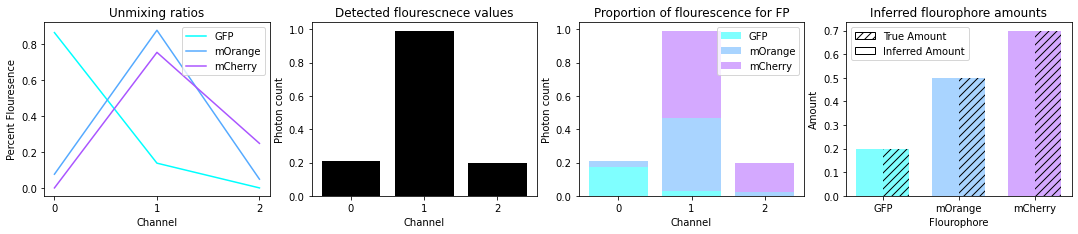

In [58]:
# @title { run: "auto" }
GFP_amount = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
mOrange_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
mCherry_amount = 0.7  # @param {type:"slider", min:0, max:1, step:0.1}
x_known = np.array([GFP_amount, mOrange_amount, mCherry_amount])

comp.main(fp_dict, filter_dict, x_known, two_channels=False)

#2. Sequential imaging
If an additional channel cannot be added, or would not yield sufficient seperability, then you must rely on sequentially acquired images that are registered to eachother, to capitalize on alternative filter sets or excitation wavelengths. 

###Not good for Activity indicators
* It should be noted that this is not really an option if you need to demix in real time, or at the single pixel resolution. For example if you are trying to demix multiple activity indicators (GECI, GEVI, GluSNFR, etc. and/or a structural marker for normalization) then you really need as many or more channels as flourophores. 

###Not good for subcellular resolution
* Furthermore, demixing subcellular structures (like synapses), has only been done using multiple simultaneously acquired channels (Nedivi lab). Its possible that sequential images could be used, if the resolution was high enough and the registration accurate enough to ensure that the same subcellular structures corresponded to the same pixels. 

###Should be sufficient for sizeable, stable structures
* To my knowledge, this has not been shown using in-vivo 2photon, but I am confident that for stable, well defined structures, we should be able to sucessfully mix entire ROIs. Anything that can be consistently tracked and registered from session to session. Somas, beint the largest will be easiest, but I believe boutons will be feasible as well, especially if we use a structural marker that is visible in all sequential imaging sessions. The dream for me is to use multiple colors to identify the nature of presynaptic cells corresponding to each spine on a single neuron. 

**(One possible alternative to sequential imaging is to interleave different excitation wavelengths so that pixels are acquired at nearly the same time which is possible with the Femtonics Atlas...)

#2a. Sequential imaging with different filter sets
If we are limited to 2 PMTs, we can do multiple rounds of imaging seperating the florescence in different ways. We can imagine using dedicated narrow filter sets for each flourophore, and repeating until we have accounted for each flourophore, or we could use broader filter sets that maximize the photons collected but rely more heavily on unmixing. Additional work will be necessary to assess which method to use, but here is proof of concept:

3


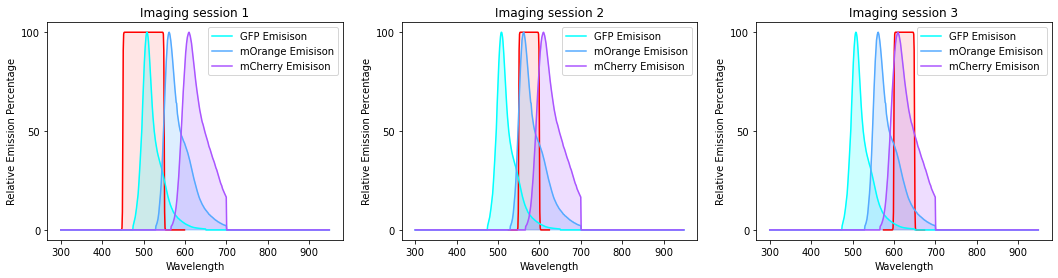

In [67]:
all_filters["Orange Filter"] = comp.create_filter(575, 50, max_em=100, steepness=10)
all_filters["FR Filter"] = comp.create_filter(625, 50, max_em=100, steepness=10)

fp_dict = get_sub_dict(["GFP", "mOrange", "mCherry"], all_fps)
filter_set_list: list[dict] = [
    get_sub_dict(["Green Filter"], all_filters),
    get_sub_dict(["Orange Filter"], all_filters),
    get_sub_dict(["FR Filter"], all_filters),
]

plot.ex_em_spectra(fp_dict, filter_set_list=filter_set_list)

Its easiest to conceptualize using a seperate imaging session for each flourophor as above. This isn't necessary however, so we will also consider the slighlty less laborious scenario that rewuires two imaging sessions and switching one filter. 

2


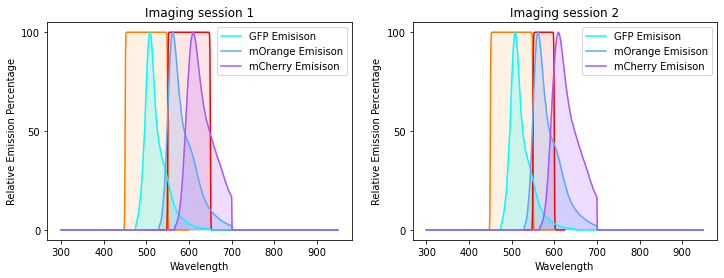

In [68]:
fp_dict = get_sub_dict(["GFP", "mOrange", "mCherry"], all_fps)
filter_set_list: list[dict] = [
    get_sub_dict(["Green Filter", "Red Filter"], all_filters),
    get_sub_dict(["Green Filter", "Orange Filter"], all_filters),
]

plot.ex_em_spectra(fp_dict, filter_set_list=filter_set_list)

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_inferred, res, rank, s = np.linalg.lstsq(A, b)


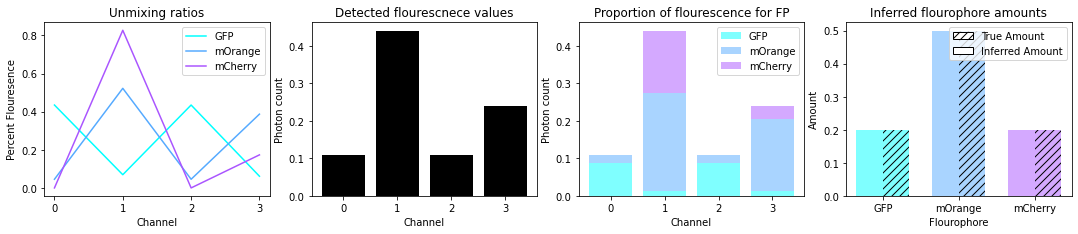

In [69]:
# title {run: auto}

GFP_amount = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
mOrange_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
mCherry_amount = 0.2  # @param {type:"slider", min:0, max:1, step:0.1}
x_known = np.array([GFP_amount, mOrange_amount, mCherry_amount])

comp.main(fp_dict, filter_set_list, x_known)

#2b. Sequantial imaging with different excitation wavelengths
In some cases it may be inconvenient or impossible to change the filter sets. In these cases you can use multiple excitation wavelengths. In some cases this may be necessary to get sufficient excitation from each of the flourophores (i.e. you will likely need to lower the wavelength to excite blue fluorophores). 

The ideal excitiation wavelengths will create the most seperability between the floresence produced. In most cases this will probably mean targeting 1 or more excitation peaks, and taking advantage of the sharp dropoff in excitation at higher wavelengths. Its important to note that the 2P excitation spectra is not simply a doubled version of the 1P excitation spectra. The two photon excitation spectra are typically broader and blue shifted relative to a doubled version of the 1P. For this proof of concept example we will ignore this phenomenon, but we will address it later when assessing noise and realistic feasibility. 

4


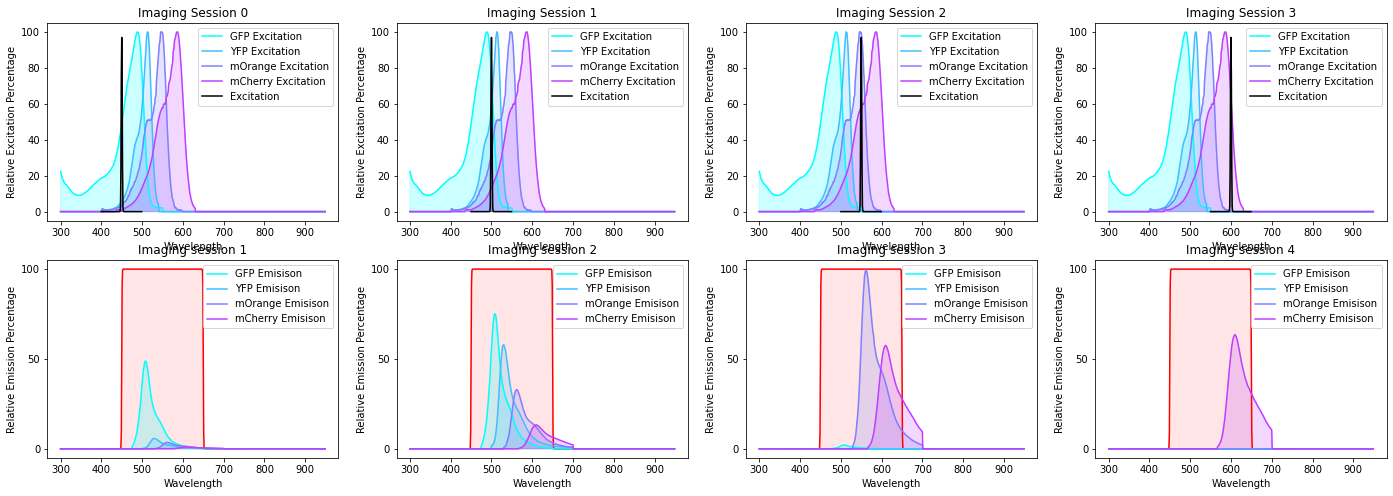

In [74]:
all_filters["Broad Filter"] = comp.create_filter(550, 200, max_em=100, steepness=10)
fp_dict = get_sub_dict(["GFP", "YFP", "mOrange", "mCherry"], all_fps)
filter_set_list: list[dict] = [get_sub_dict(["Broad Filter"], all_filters)]

plot.ex_em_spectra(
    fp_dict, filter_set_list=filter_set_list, excitation_list=[450, 500, 550, 600]
)

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:38: FutureWarning: `rcond` parameter will change to the default of machine precision times ``max(M, N)`` where M and N are the input matrix dimensions.
To use the future default and silence this warning we advise to pass `rcond=None`, to keep using the old, explicitly pass `rcond=-1`.
  x_inferred, res, rank, s = np.linalg.lstsq(A, b)


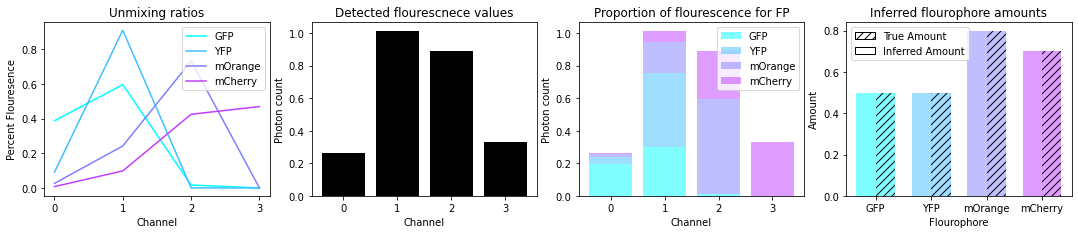

In [77]:
GFP_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
mOrange_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
mCherry_amount = 0.8  # @param {type:"slider", min:0, max:1, step:0.1}
yfp_amount = 0.7
x_known = np.array([GFP_amount, mOrange_amount, mCherry_amount, yfp_amount])
()
comp.main(fp_dict, filter_set_list, x_known, excitation_list=[450, 500, 550, 600])

#Introducing noise
Lets return to a simple 2 flourophore-2 channel example to look at what happens when we introduce noise to the imaging process. We will look at two highly overlapping flourophores, GFP and CFP with a standard red green filter a a baseline far-from-optimal scenario. 



1


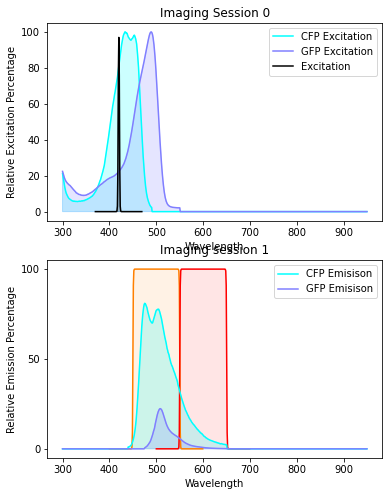

In [93]:
excitation_wavelength = 420
fp_dict = get_sub_dict(["CFP", "GFP"], all_fps)
filter_set_list: list[dict] = [
    get_sub_dict(["Green Filter", "Red Filter"], all_filters)
]

plot.ex_em_spectra(
    fp_dict, filter_set_list=filter_set_list, excitation_list=[excitation_wavelength]
)

First lets add some randomness to the photons being produced by the laser - the actual wavelength of photons produced  and the total number of photons will be sampled form a guassian distribution. We do not expect there to be much variance in the power, since other sources of shot noise likely outweigh this one. Also We are not actually trying to account for the full number of realistic photons here, but just enough to introduce reasonable variability. 

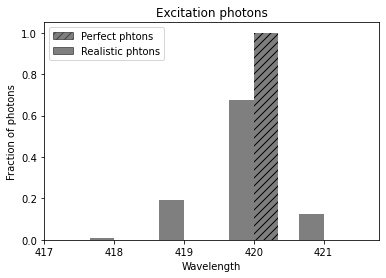

In [88]:
num_photons = 100  # @param {type:"slider", min:0, max:1000, step:10}

wavelength_sd = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
power_sd = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}

CFP_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
GFP_amount = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}

amount_dict = {"CFP": CFP_amount, "GFP": GFP_amount}

perfect_photons = comp.get_photons(num_photons, 0, excitation_wavelength, 0)
realistic_photons = comp.get_photons(
    num_photons, power_sd, excitation_wavelength, wavelength_sd
)
plot.plot_photons(realistic_photons, perfect_photons)

Next we need to account for two things to make flourophore excitation more realistic. First the two photon excitation spectra is not identical to the one photon. It is broader and slightly blue shifted. Second, we want the interaction between the flourophores and the photons to be probabilistic. For each photon we draw from a uniform random distrubtion and threshold based on the value of the 2P excitation spectra at that wavelength so that an appropriate fraction of photons sucessfully induce emission. We then sample this number of photons from the emission distribution to determine their wavelength. 

1
['CFP', 'GFP']


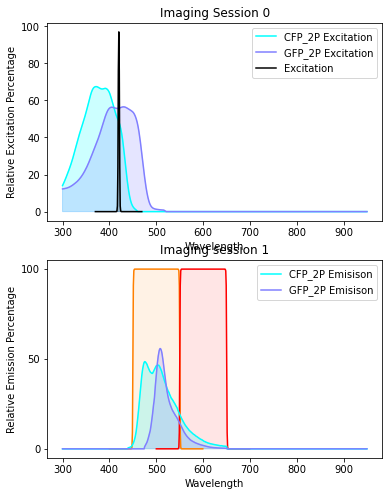

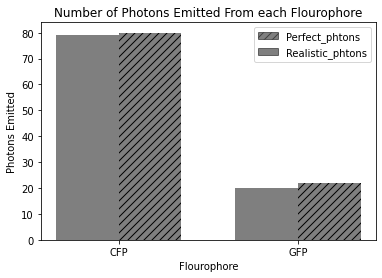

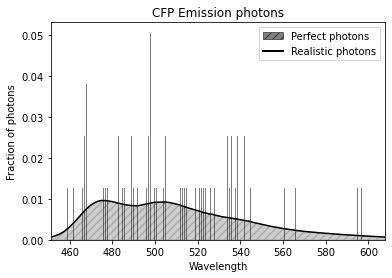

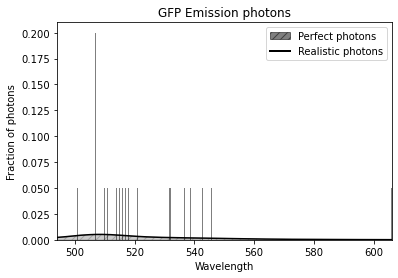

In [101]:
# get the photons from the result of excitation
excited_fp_dict, emission_photons, spectra_dict_2p = comp.model_fp_excitation(
    fp_dict, realistic_photons, perfect_photons
)

# re-plot the spectra with the 2P excitations
plot.ex_em_spectra(
    spectra_dict_2p,
    filter_set_list=filter_set_list,
    excitation_list=[excitation_wavelength],
)

# plot the number of photons from each flouropohore
plot.plot_emission_count(excited_fp_dict)

# plot the Emissione wavelengths of each flourophore
for FP, phton_dict in emission_photons.items():
    plot.plot_photons(
        phton_dict["realistic"], phton_dict["perfect"], title=f"{FP} Emission photons"
    )

/Users/greggoryheller/Documents/code/PMT_linearization/src/demo_computation.py:17: RuntimeWarning: overflow encountered in power
  1 / (1 + steepness ** (-(wavelengths - (wavelength + bandwidth / 2))))


1
1


KeyError: '[200] not in index'

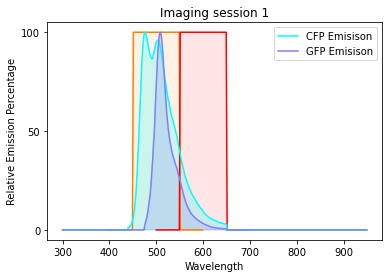

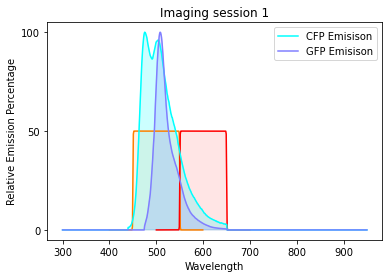

In [145]:
# parameters for filters
filter_max_transmission = 0.5  # @param {type:"slider", min:0, max:1, step:0.1}
filter_steepness = 5  # @param {type:"slider", min:0, max:10, step:1}
filter_wavelenght_list = [500, 600]
bandwidth = 100

realistic_filters, perfect_filters = comp.create_filters(
    filter_wavelenght_list, bandwidth, filter_max_transmission * 100, filter_steepness
)
plot.ex_em_spectra(fp_dict, filter_set_list=perfect_filters)
plot.ex_em_spectra(fp_dict, filter_set_list=realistic_filters)


combined_photons, combined_em_df = comp.combine_photons(emission_photons)
realistic_photons_after_filters = []
realistic_counts_after_filters = []
perfect_photons_after_filters = []
for filter_df in realistic_filters.values():
    passed_phtons = comp.apply_filter_stochastic(
        combined_photons, filter_df, fraction_photons_reaching_filter=1
    )
    realistic_photons_after_filters.append(passed_phtons)
    realistic_counts_after_filters.append(len(passed_phtons))
ax = plot.plot_flourescence_vals(realistic_photons_after_filters)
ax.set_title("Realistic Photons after filters")

for filter_df in perfect_filters:
    perfect_photons_after_filters.append(comp.apply_filter(combined_em_df, filter_df))
ax = plot.plot_flourescence_vals(realistic_photons_after_filters)
ax.set_title("Perfect Photons after filters")

PMT = comp.create_PMT()
photons_detcted = []
for photons in realistic_photons_after_filters:
    photons_detcted.append(len(comp.apply_PMT_stochastic(photons, PMT)))

ax = plot.plot_flourescence_vals(photons_detcted)
ax.set_title("Realistic Photons Detected")

# plot

,Wavelength,Emission
0,600,0.0
1,602,0.0
2,604,0.0
3,606,0.0
4,608,0.0
...,...,...
645,1890,0.0
646,1892,0.0
647,1894,0.0
648,1896,0.0



#Make sure you add sliders and include in analysis for photon loss on both halves - might be relying on defaults right now

then produce a summary from lots of combinations of flourophore possibilitie
- run 100x, produce a bar plot with the scatter of the individual points, average should approach accurat
- demonstrate mean and std
produce mean and standard plots as you vary a parameter - holding the others constant at 1 or some intermediate value
- think about fitting something to this? the slope/half width max of the STD may be enough. Then we can plot this value against the different flourophore values. Alternatively, once we subtract the mean we can just lump all the different flourophore values together, but I think it would be useful to do both in order to see if there are any dependancies.

produce example unmixing plots - raw scatter plot, unmixing vect and hist around mean at different points.

exemplify how there are only 2 effects, decreased signal or incresased noise (do this with a slider plot)

Show a real unimxing plot - show that the linearity affects the higher values while the other effects affect lower values

compute the two values/metrics that the other paper used


Then make the end to end simulator with all the parameters


Then need to include bleaching for multiple images - save this for last since it should be included in the unmixing images


